<a href="https://colab.research.google.com/github/vpw/TSAI-END3/blob/main/Ass2.5/END3_MNIST_addnumber_ass2_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quick Start PyTorch - MNIST

To run a Code Cell you can click on the `⏯ Run` button in the Navigation Bar above or type `Shift + Enter`

In [1]:
#pip install --force-reinstall torch==1.2.0 torchvision==0.4.0 -f https://download.pytorch.org/whl/torch_stable.html

In [30]:
%pylab inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST
from torchsummary import summary

SEED = 1

# CUDA?
use_cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)

if use_cuda:
    torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if use_cuda else "cpu")

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Preparing the Dataset

The 

MNIST dataset is normalized to [0,1] range as per the explanation here: https://stackoverflow.com/questions/63746182/correct-way-of-normalizing-and-scaling-the-mnist-dataset

The dataset has the input MNIST image, a onehot encoding of a random number generated per test case, and the output which consists of the concatenation of the MNIST number (onehot) and a binary (decimal to binary) encoding of the sum. As the sum can vary from 0 to 19, 5 binary digits are needed, the dimension of the model output is hence 10+5 = 15 nodes. The target for MNIST is the MNIST label (instead of the one host encoding) so it is appended to the 5 digit sum.


In [3]:
class MNIST_add_dataset(Dataset):
  def __init__(self, trainset=True):
    self.trainset=trainset
    self.mnist_set = MNIST('./data', train=self.trainset, download=True, 
                                transform=transforms.Compose([
                                    transforms.ToTensor(), # ToTensor does min-max normalization.
                                    transforms.Normalize((0.1307,), (0.3081,))
                                ]), )
    # list of random integers for adding - part of training set
    self.rand_int_num_list = [np.random.randint(0,10) for i in range(len(self.mnist_set))]
    #print("Rand int ",self.rand_int_num_list[0])
    # convert it to 1 hot encoding for use in training
    self.num_onehot = np.identity(10)[self.rand_int_num_list]    
    #print("Rand int one hot ",self.num_onehot[0])
    # get the list of MNIST digits
    self.digit_list = list(map(lambda x:[x[1]], self.mnist_set))
    #print("MNIST digit ",self.digit_list[0], len(self.digit_list))
    # get the final train target label by summing the MNIST label and the random number
    # and get the binary (5 digit) representation of the sum of the MNIST digit and the random number
    self.bin_sum_list = list(map(lambda x,y: list(map(int,f'{x[1]+y:05b}')), self.mnist_set, self.rand_int_num_list))
    #print("Binary of sum ",self.bin_sum_list[0])
    # set the target as a concatenation of the MNIST label and the binary encoding of the sum of the 
    # MNIST number and the random number
    self.target = list(map(lambda x,y:np.concatenate((x,y)),self.digit_list,self.bin_sum_list))
    #print("Target ",self.target[0])
  def __getitem__(self, index):
    # MNIST image input
    image = self.mnist_set[index][0]
    # One hot encoding of the random number
    oh_num = torch.as_tensor(self.num_onehot[index],dtype=torch.float32)
    # concatenated target
    target = torch.tensor(self.target[index])
    return ([image, oh_num],target)        
  def __len__(self):
    return len(self.mnist_set)                          

# Make the train and test datasets

In [4]:
train_set = MNIST_add_dataset(trainset=True)
test_set = MNIST_add_dataset(trainset=False)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Visualization

# Data loader

In [5]:
dataloader_args = dict(shuffle=True, batch_size=256,num_workers=4, pin_memory=True) if use_cuda else dict(shuffle=True, batch_size=64)
train_loader = dataloader.DataLoader(train_set, **dataloader_args)
test_loader = dataloader.DataLoader(test_set, **dataloader_args)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Model

The model consists of 3 convolutional blocks, followed by 3 linear blocks, with ReLU activation in between. The MNIST image is fed to the 1st Conv block, and the ranbdom number (one hot) to the first linear block (alongwith the output of the 3rd Conv block, concatenated).

In [6]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    # conv layer 1
    self.conv1 = nn.Sequential(
                          
        nn.Conv2d(1,16,5), # 16x24x24
        nn.ReLU(),
        nn.MaxPool2d(2,2)  # 16x12x12
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(16,32,5), # 32x8x8
        nn.ReLU(),
        nn.MaxPool2d(2,2)  # 32x4x4
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(32,10,3), # 10x2x2
        nn.MaxPool2d(2,2)   # 10x1x1
    )
    self.relu = nn.ReLU()
    self.fc1 = nn.Linear(10+10, 60) # adding random number one hot to the 1x10 MNIST output
    self.fc2 = nn.Linear(60, 30)
    self.fc3 = nn.Linear(30, 15) # 10 for MNIST 1-hot coding, and 5 for binary repr of sum of digits

  def forward(self, image, number):
    #print("0 ",image.shape)
    x = self.conv1(image)
    #print("1 ",x.shape)
    x = self.conv2(x)
    #print("2 ",x.shape)
    x = self.conv3(x)
    #print("3 ",x.shape)
    x = x.view(-1,10)
    #print("after ",x.shape)
    # concatenate the number
    x = torch.cat((x,number),1)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    x = x.view(-1,15)
    #print("In forward x shape ",x.shape)
    
    # The first 10 outputs should be the onehot encoding of the MNIST digit
    # using a Log softmax (with NLL Loss) for this
    o1 = F.log_softmax(x[:,:10])
    #print("In forward o1 shape ",o1.shape)

    # for the 5 digit sum outout - as it is a multi-label classification, I am using a Sigmoid and not a softmax as there
    # will be multiple 1's in the output
    # used Hardsigmoid as it has a more sharp curve
    sig = nn.Hardsigmoid()
    o2 = sig(x[:,10:])
    #print("In forward o2 shape ",o2.shape)
    return torch.cat((o1,o2),1)

In [32]:
model = Model().to(device)
print(model)
# random test
model.forward(torch.rand((1, 1, 28, 28)).to(device), torch.rand((1, 10)).to(device))

Model(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (relu): ReLU()
  (fc1): Linear(in_features=20, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=15, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[-2.1280, -2.3497, -2.3076, -2.2818, -2.1473, -2.3670, -2.3914, -2.4043,
         -2.3156, -2.3768,  0.5047,  0.4931,  0.4800,  0.4763,  0.4750]],
       device='cuda:0', grad_fn=<CatBackward>)

In [24]:

def train(model, device, train_loader, optimizer, epoch, losses):
    print(f"EPOCH - {epoch}")
    model.train()
    for batch_idx, (input, target) in enumerate(train_loader):
        image, number, target = input[0].to(device), input[1].to(device), target.to(device)
        # clear the grad computation
        optimizer.zero_grad()
        y_pred = model(image, number)  # Passing batch
        #print("Input shape ", input.shape)
        #print(len(image))
        #print("Image shape ", image.shape)
        #print("Number shape ", number.shape)
        #print("Target shape ",target.shape)
        #print("Ypred shape ",y_pred.shape)
        
        # Calculate loss
        #print(target[:,0].shape)
        #print(y_pred[:,:10])
        # using 2 losses - one for the MNIST prediction and one for the sum (binary)
        # using Negative log likelihood for the MNIST prediction as we used Log Softmax for the activation
        loss_nll = nn.NLLLoss()
        loss1 = loss_nll(y_pred[:,:10],target[:,0])
        
        
        # Using Binary cross entropy for the binary sum representation
        loss_bce = torch.nn.BCELoss()
        loss2 = loss_bce(y_pred[:,10:].float(),target[:,1:].float())

        # Total loss
        loss=loss1+loss2
        #print("Loss1 ",loss1.cpu().data.item())
        #print("Loss2 ",loss2.cpu().data.item())
        #print("Loss ",loss.cpu().data.item())
        losses.append(loss.cpu().data.item())
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        # Display
        if batch_idx % 100 == 0:
            print('\r Train Epoch: {}/{} \
            [{}/{} ({:.0f}%)]\
            \tAvg Loss: {:.6f}'.format(
                epoch+1,
                EPOCHS,
                batch_idx * len(image), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.cpu().data.item()/256), 
                end='')

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct_MNIST = 0
    correct_sum = 0
    correct = 0
    with torch.no_grad(): # dont compute gradients 
        for data, target in test_loader:
            image, number, target = data[0].to(device), data[1].to(device), target.to(device)
            # get prediction
            output = model(image, number)
            #print(output.shape, target.shape)
            #print("Output ",output,"\nTarget ", target)
            
            # compute loss
            loss_nll = nn.NLLLoss()
            loss1 = loss_nll(output[:,:10],target[:,0]).item()
            
            loss_bce = torch.nn.BCELoss()
            loss2 = loss_bce(output[:,10:].float(),target[:,1:].float()).item()
            
            loss = loss1+loss2
            
            #print("Loss1 ",loss1.cpu().data.item())
            #print("Loss2 ",loss2.cpu().data.item())
            #print("Loss ",loss.cpu().data.item())

            test_loss += loss  # sum up batch loss

            #pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            #correct += pred.eq(target.view_as(pred)).sum().item()

            pred_MNIST = output[:,:10].argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct_MNIST_list = pred_MNIST.eq(target[:,0].view_as(pred_MNIST))
            correct_MNIST += correct_MNIST_list.sum().item()
            pred_sum = output[:,10:]
            correct_sum_list = pred_sum.eq(target[:,1:].view_as(pred_sum))
            correct_sum += correct_sum_list.sum().item()
            correct_list = torch.logical_and(correct_MNIST_list, correct_sum_list)
            correct += correct_list.sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, \
        Accuracy-MNIST: {}/{} ({:.0f}%)\t\
        Accuracy-sum: {}/{} ({:.0f}%)\t\
        Accuracy-total: {}/{} ({:.0f}%)\n'.format(
        test_loss, 
        correct_MNIST, len(test_loader.dataset),
        100. * correct_MNIST / len(test_loader.dataset),
        correct_sum, len(test_loader.dataset),
        100. * correct_sum / len(test_loader.dataset),
        correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [29]:
model = Model().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS=20
losses = []

for epoch in range(EPOCHS):
    train(model, device, train_loader, optimizer, epoch, losses)
    test(model, device, test_loader)


EPOCH - 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


 Train Epoch: 1/20             [51200/60000 (85%)]            	Avg Loss: 0.004698
Test set: Average loss: 0.0042,         Accuracy-MNIST: 9073/10000 (91%)	        Accuracy-sum: 4749/10000 (47%)	        Accuracy-total: 4547/10000 (45%)

EPOCH - 1
 Train Epoch: 2/20             [51200/60000 (85%)]            	Avg Loss: 0.002582
Test set: Average loss: 0.0030,         Accuracy-MNIST: 9634/10000 (96%)	        Accuracy-sum: 6459/10000 (65%)	        Accuracy-total: 6270/10000 (63%)

EPOCH - 2
 Train Epoch: 3/20             [51200/60000 (85%)]            	Avg Loss: 0.002450
Test set: Average loss: 0.0029,         Accuracy-MNIST: 9731/10000 (97%)	        Accuracy-sum: 7042/10000 (70%)	        Accuracy-total: 6902/10000 (69%)

EPOCH - 3
 Train Epoch: 4/20             [51200/60000 (85%)]            	Avg Loss: 0.002783
Test set: Average loss: 0.0030,         Accuracy-MNIST: 9786/10000 (98%)	        Accuracy-sum: 7285/10000 (73%)	        Accuracy-total: 7165/10000 (72%)

EPOCH - 4
 Train Epoch: 5/

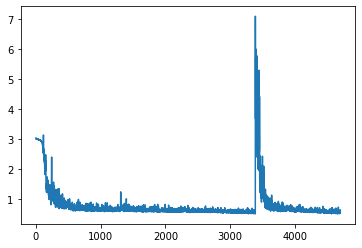

In [33]:
plot(losses)

## Evaluate

In [ ]:
evaluate_x = Variable(test_loader.dataset.data.type_as(torch.FloatTensor()))
evaluate_y = Variable(test_loader.dataset.targets)
if cuda:
    evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()

model.eval()
output = model(evaluate_x)
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()
accuracy = d.sum().item()/d.size().numel()

print('Accuracy:', accuracy*100.0)

In [ ]:
npi = evaluate_x.cpu().detach().numpy()
npo = output.cpu().detach().numpy()
for index in range(1):
  print(npi[index])
  print(npo[index])

In [ ]:
dummy_input = torch.randn(784, device='cuda')
torch.onnx.export(model, (dummy_input), "mnist.onnx", verbose=True)
#                  input_names=input_names, output_names=output_names)


In [ ]:
pip install onnx==1.5.0


In [ ]:
import onnx
model=onnx.load_model('mnist.onnx')
print(model)